In [1]:
import onnx
import onnxruntime
import tvm
from tvm import relay, transform
from tvm.contrib import graph_executor as runtime
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
import cv2
import numpy as np
import logging

logging.basicConfig(level=logging.ERROR)

In [2]:
model_dir = Path.cwd().parent / "models" / "modnet"
model_dir.exists()

True

In [3]:
model_path = model_dir / "modnet.onnx"
model_path.exists()

True

In [4]:
onnx_model = onnx.load(str(model_path))
onnx_model.graph.input

[name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch_size"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_param: "height"
      }
      dim {
        dim_param: "width"
      }
    }
  }
}
]

In [5]:
target = "llvm"

input_name = "input"
input_dtype = "float32"
input_shape = (1, 3, 320, 320)
shape_dict = {input_name: input_shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict, freeze_params=True)

target = "llvm"
with transform.PassContext(opt_level=0):
    lib = relay.build(mod, target, params=params)
    lib.export_library(str(model_path.with_suffix(".so")))

In [6]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))

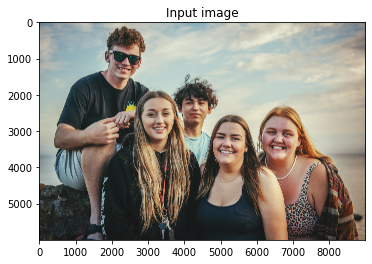

In [12]:
assets_dir = Path.cwd().parent / "assets"
original_image = imageio.imread(assets_dir / "multiple_faces_image.jpg")
r, c, _ = original_image.shape
plt.imshow(original_image)
plt.title("Input image")
plt.show()

In [8]:
image = cv2.resize(original_image, (320, 320), cv2.INTER_AREA)
image_mean = np.array([127, 127, 127])
image = (image - image_mean) / 128
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)
print(image.shape)
print(image.dtype)

(1, 3, 320, 320)
float32


In [9]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))
module.set_input("input", tvm.nd.array(image))
module.run()
segmentation_map = np.squeeze(module.get_output(0).numpy() * 255).astype(np.uint8)
print(segmentation_map.shape)
print(np.min(segmentation_map), np.max(segmentation_map))

(320, 320)
0 254


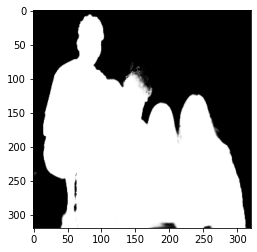

In [10]:
f = plt.figure()
plt.imshow(segmentation_map, cmap='gray')
plt.show()

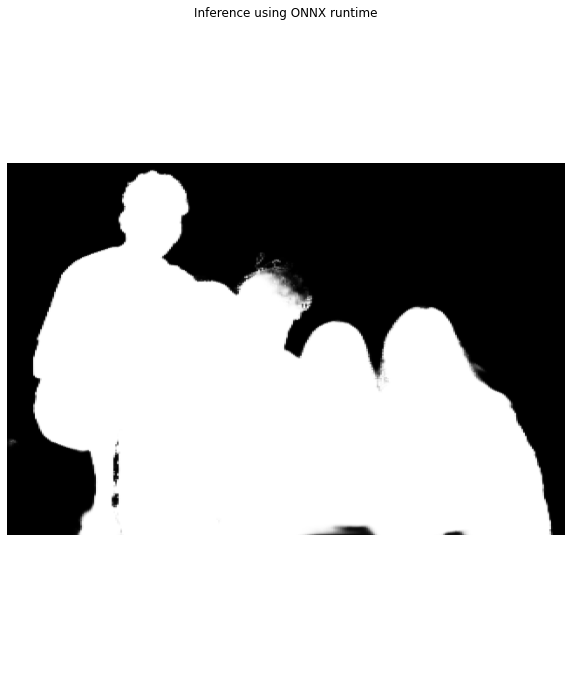

In [15]:
session = onnxruntime.InferenceSession(str(model_path), None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
result = session.run([output_name], {input_name: image})
matte = (np.squeeze(result[0]) * 255).astype('uint8')
matte = cv2.resize(matte, dsize=(c, r), interpolation = cv2.INTER_AREA)
f = plt.figure(figsize=(10, 12))
plt.imshow(matte, cmap='gray')
plt.title("Inference using ONNX runtime")
plt.axis('off')
plt.axis('equal')
plt.show()

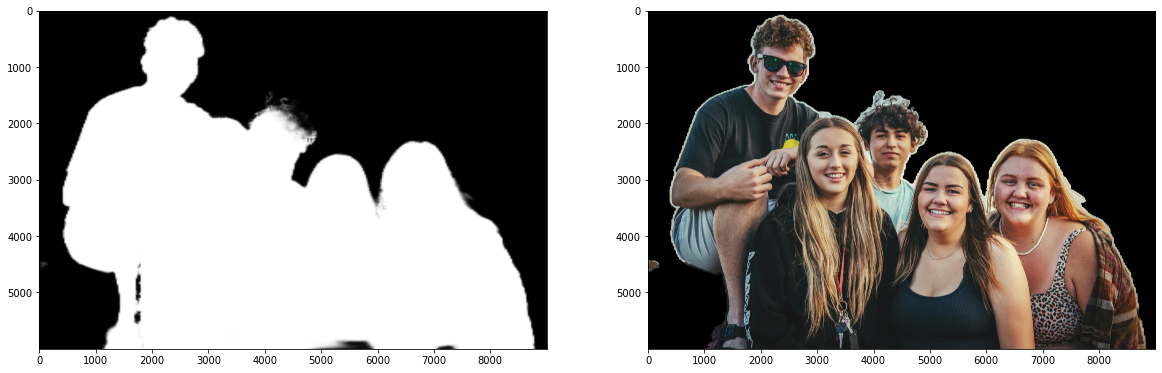

In [14]:
seg_mask = cv2.resize(segmentation_map, (c,r))
image_copy = original_image.copy()
image_copy[seg_mask == 0] = 0
f, ax = plt.subplots(1,2)
f.set_size_inches((20, 25))
ax[0].imshow(seg_mask, cmap='gray')
ax[1].imshow(image_copy)
plt.show()

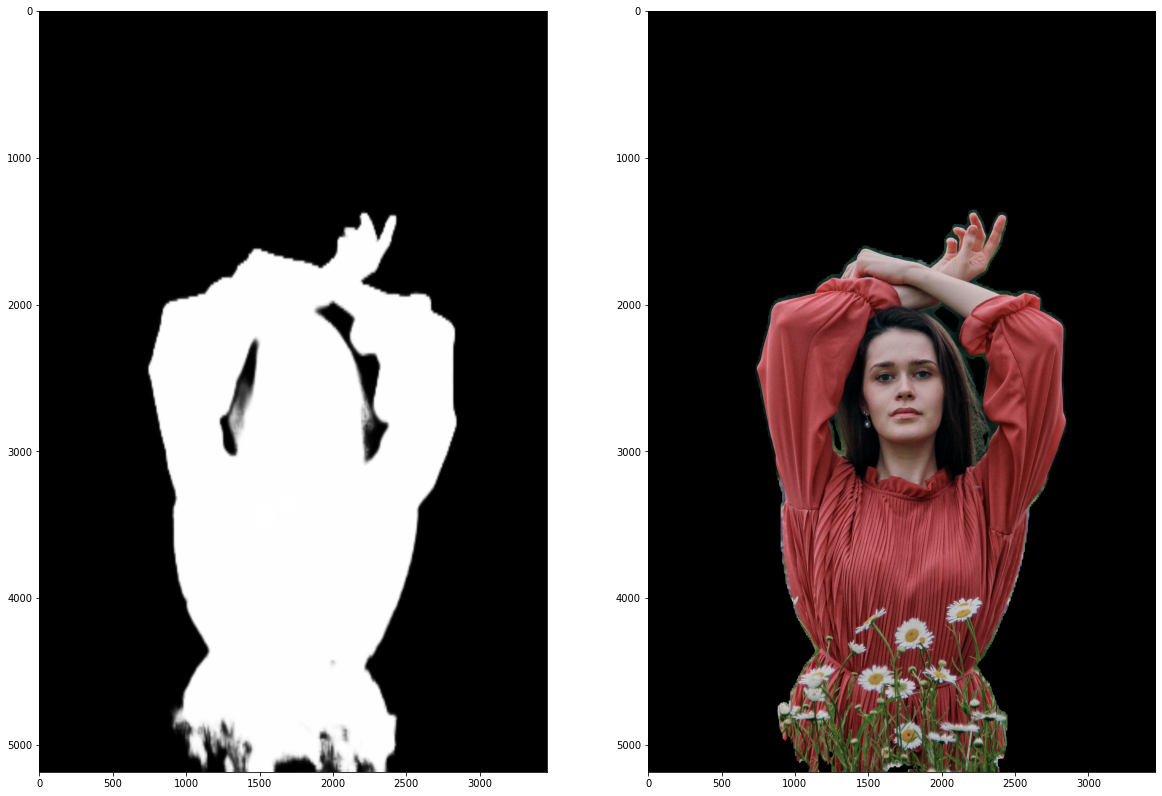

In [17]:
original_image = imageio.imread(assets_dir / "single_image.jpg")
r, c, _ = original_image.shape

image = cv2.resize(original_image, (320, 320), cv2.INTER_AREA)
image_mean = np.array([127, 127, 127])
image = (image - image_mean) / 128
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)

module.set_input("input", tvm.nd.array(image))
module.run()
segmentation_map = np.squeeze(module.get_output(0).numpy() * 255).astype(np.uint8)

seg_mask = cv2.resize(segmentation_map, (c,r))
image_copy = original_image.copy()
image_copy[seg_mask == 0] = 0
f, ax = plt.subplots(1,2)
f.set_size_inches((20, 25))
ax[0].imshow(seg_mask, cmap='gray')
ax[1].imshow(image_copy)
plt.show()